<a href="https://colab.research.google.com/github/oublalkhalid/MoroccoAI-Data-Challenge/blob/main/Detect_Morocco_Plates_YoloFN_Detect_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETECT MOROCCO PLATES LICENSES (YoloFN Detect + Recognition Part IV) 
**Submission Model**

Our goal is to detect the number lisense  **XXXX-ﺏ-YY** or **XXXX-ش-YY**.. as **XXXX-b-YY**, **XXXX-p-YY** ....; To do this, we will combine all the deep learning framwork that we have made on part 0,1,2 and 3.


# **Connecting Drive and creating a sym link**

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
# Creating SymLink
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive


 Assessment_OUBLAL-Khalid.ipynb
'Ballon Project - Documents'
'Centrale Lyon 2020'
'Colab Notebooks'
 cora
 Cours_space_mechanics
 data
 Data-IA
 Detector
 gain
 Image_TP4
 INF554
 INF554-khalid
'ISAE SUPAERO 2021'
 khalid_me.png
 khalid.png
'Les gain'
'Les Relevés'
'M2 TSI'
'Ma famille '
'ML Lectures_polytechnique'
 MoroccoAI-challenge-OUBLAL-2021
'My Drive'
"Programmation X-l'ORIENTation"
'Python projet'
 Readme.md
 ResNet32.pth
 Resnet_Pretrained18.pth
 ResNet.pth
 Soutenance_OUBLAL-Khalid-2021-Septembre.pdf
'Tactics for TOEIC'
'TP2 corrélation'
 TP_Bruit
 TP_Capteur
 TP-OMR
'TP space thermal - Model using SYSTEMA Software'
 Untitled0.ipynb
 VGGNet.pth
 vgg_pred.pth
 vlcsnap-7084-07-07-11h09m08s377.png
 vlcsnap-7952-05-12-10h20m40s308.png


### **Copy weights, configs, and models to Colab VM**


In [ ]:
# YOLOv3 configs and weights
path='/content/gdrive/MoroccoAI-challenge-OUBLAL-2021/models/'
!cp /content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3-license-plates.cfg ../
!cp /content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_character.cfg ../
!cp /content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_plates_final.weights ../
!cp /content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_chars_final.weights ../

#CNN model
!cp /content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/cnn_flownormalizing.h5 ../



# **Functions to predict and drawings on Images**

In [ ]:
# python imports
import cv2 as cv
import tensorflow as tf
import numpy as np

In [ ]:
# Making sure to use GPU with CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# YOLOv3 model build function from weights and config 
def get_yolo_net(config, weights):
    yolo_net = cv.dnn.readNetFromDarknet(config, weights)
    yolo_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    yolo_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
    return yolo_net

In [ ]:
# YOLOv3 and CNN Parameters
confidence_threshold = 0.1  # Confidence threshold
nms_threshold = 0.6  # Non-maximum suppression threshold

yolo_net_width = 416
yolo_net_height = 416

# Load all models and configs

plates_yolo_config = "/content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3-license-plates.cfg"
plates_yolo_weights = "/content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_plates_final.weights"
plates_classes = ['Plate']
chars_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a','b','d', 'h', 'j', 'm', 'p', 'waw', 'ww']

chars_yolo_config = "/content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_character.cfg"
chars_yolo_weights = "/content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/yolov3_chars_final.weights"

plates_yolo_net = get_yolo_net(plates_yolo_config, plates_yolo_weights)
chars_yolo_net = get_yolo_net(chars_yolo_config, chars_yolo_weights)


In [ ]:
cnn_chars_model = tf.keras.models.load_model('/content/gdrive/MyDrive/MoroccoAI-challenge-OUBLAL-2021/models/cnn_chars_recognition.h5')

In [ ]:
def cnn_char_recognition(image):
    gray_char = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray_char = cv.resize(gray_char, (75, 100))
    image = gray_char.reshape((1, 100, 75, 1))
    image = image / 255.0
    predictions = cnn_chars_model.predict(image)
    max_confidence_index = np.argmax(predictions)
    return chars_classes[max_confidence_index]

def canny(image, sigma=0.33):
    lower = int(max(0, (1.0 - sigma) * np.median(image)))
    upper = int(min(255, (1.0 + sigma) * np.median(image)))
    edges = cv.Canny(image, lower, upper)
    return edges

In [ ]:
# CNN model - character recognition predictions from the image
def cnn_recognize_plate(frame):
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    thresh_inv = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 39, 1)
    edges = canny(thresh_inv)

    contours, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    sorted_ctrs = sorted(contours, key=lambda x: cv.boundingRect(x)[0])
    area = frame.shape[0] * frame.shape[1]

    chars = []
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv.boundingRect(ctr)
        roi_area = w * h
        non_max_sup = roi_area / area

        if (non_max_sup >= 0.015) and (non_max_sup < 0.09):
            if (h > 1.2 * w) and (3 * w >= h):
                char = frame[y:y + h, x:x + w]
                chars.append(cnn_char_recognition(char))
                cv.rectangle(frame, (x, y), (x + w, y + h), (90, 0, 255), 2)
    license_plate = "".join(chars)
    print(license_plate)
    return license_plate


In [ ]:
def process_license_plate(license_plate):
    gray = cv.cvtColor(license_plate, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray, 127, 255, 0)

    contours, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    areas = [cv.contourArea(c) for c in contours]

    if len(areas) != 0:
        max_index = np.argmax(areas)
        cnt = contours[max_index]
        x, y, w, h = cv.boundingRect(cnt)
        cv.rectangle(license_plate, (x, y), (x + w, y + h), (0, 255, 0), 2)
        processed_license_plate = license_plate[y: y + h, x: x + w]
    else:
        processed_license_plate = license_plate

    return processed_license_plate

In [ ]:
def draw_pred(frame, name, conf, left, top, right, bottom, color=(0, 255, 0)):
    cv.rectangle(frame, (left, top), (right, bottom), color, 3)
    label = name
    label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, label_size[1])
    cv.rectangle(frame, (left, top - round(1.5 * label_size[1])),
                 (left + round(1.5 * label_size[0]), top + base_line), (0, 0, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 1)


In [ ]:
# For YOLOv3 model prediction
def resize_license_plate(license_plate):
    scale_percent = 300  # percent of original size
    width = int(license_plate.shape[1] * scale_percent / 100)
    height = int(license_plate.shape[0] * scale_percent / 100)
    return cv.resize(license_plate, (width, height), interpolation=cv.INTER_AREA)


In [ ]:
# For YOLOv3 model prediction
def predict_boxes(frame, yolo_outputs, is_license_plate=True):
    classes = []
    confidences = []
    boxes = []

    max_confidence = 0.0
    for output in yolo_outputs:
        for prediction in output:
            scores = prediction[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            max_confidence = max(confidence, max_confidence)
            if confidence > confidence_threshold:
                center_x = int(prediction[0] * frame.shape[1])
                center_y = int(prediction[1] * frame.shape[0])

                width = int(prediction[2] * frame.shape[1])
                height = int(prediction[3] * frame.shape[0])
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)

                classes.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    indices = cv.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    positions = []
    chars = []

    for index in indices:
        index = index[0]
        box = boxes[index]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]

        positions.append(left)

        if is_license_plate and max_confidence == confidences[index]:
            # Draw prediction rectangle for License Plate
            license_plate = frame[top: top + height, left: left + width]
            cv.rectangle(frame, (left, top), (left + width, top + height), (0, 255, 0), 3)

            # Process Licence plate to cover to Gray and to enhance contours
            processed_license_plate = process_license_plate(license_plate)

            draw_pred(frame, plates_classes[0], confidences[index], left, top, left + width, top + height)
            return "", processed_license_plate
        else:
            char = chars_classes[classes[index]]
            chars.append(char)
            draw_pred(frame, char, confidences[index], left, top, left + width, top + height, color=(90, 0, 255))

    sorted_chars = [x for _, x in sorted(zip(positions, chars))]
    return "".join(sorted_chars), frame

In [ ]:
def get_image_blob(image):
    return cv.dnn.blobFromImage(image, 1 / 255, (yolo_net_width, yolo_net_height), [0, 0, 0], 1, crop=False)

In [ ]:

def predict(input_path, 
            output_car_path, 
            output_license_path_original, 
            output_license_path, 
            video_path=None, 
            is_cnn=False, 
            is_image=True):
   # This function will take as arguement:

#            input_path --> PATH of Image
#            output_car_path --> Result
#            output_license_path_original --> Source 
#            output_license_path --> Result of Recognition (number XXXX-ﺏ-YY or XXXX-ش-YY.. as XXXX-b-YY, XXXX-p-YY ....)
#            video_path=None, 
#            is_cnn=False, 
#            is_image=True


    stream = cv.VideoCapture(input_path)
    Frame_PS = 2
    # Limit number of frames per sec
    stream.set(cv.CAP_PROP_FPS, Frame_PS)

    if not is_image:
        vid_writer = cv.VideoWriter(video_path, cv.VideoWriter_fourcc('H','2','6','4'), 30, (
        round(stream.get(cv.CAP_PROP_FRAME_WIDTH)), round(stream.get(cv.CAP_PROP_FRAME_HEIGHT))))

    # Read Frames from the file if video, else read first frame from image
    while cv.waitKey(1) < 0:
        exists, frame = stream.read()
        if not exists:
            cv.waitKey(2000)
            print("End of frames")
            vid_writer.release()
            break

        # DETECT LICENSE PLATE
        car_image_blob = get_image_blob(frame)

        # Feed the input image to the Yolo Network
        plates_yolo_net.setInput(car_image_blob)

        # Get All Unconnected Yolo layers
        plates_yolo_layers = [plates_yolo_net.getLayerNames()[i[0] - 1] for i in
                              plates_yolo_net.getUnconnectedOutLayers()]

        # Forward pass the input to yolov3 net and get outputs
        plates_output = plates_yolo_net.forward(plates_yolo_layers)

        # Remove the bounding boxes with low confidence and draw box for license plate
        license_num, processed_license_plate = predict_boxes(frame, plates_output)
        if is_image:
            cv.imwrite(output_license_path_original, processed_license_plate.astype(np.uint8))

        if not is_cnn:
            # IDENTIFY LICENSE PLATE NUMBER USING YOLOV3

            # Resize the license plate so we can feed it to the second trained yolo network
            resized_license_plate = resize_license_plate(processed_license_plate)

            license_plate_image_blob = get_image_blob(resized_license_plate)
            # license_plate_image_blob = np.reshape(license_plate_image_blob, (1, 3, yolo_net_width,
            # yolo_net_height))

            # Feed the input image to the Yolo Network
            chars_yolo_net.setInput(license_plate_image_blob)

            # Get All Unconnected Yolo layers
            chars_yolo_layers = [chars_yolo_net.getLayerNames()[i[0] - 1] for i in
                                 chars_yolo_net.getUnconnectedOutLayers()]

            # Forward pass the input to yolov3 net and get outputs
            chars_output = chars_yolo_net.forward(chars_yolo_layers)

            license_number, processed_license_plate = predict_boxes(processed_license_plate, chars_output, is_license_plate=False)
            print(license_number)

        elif is_cnn:
            # IDENTIFY LICENSE PLATE NUMBER USING CNN
            license_number = cnn_recognize_plate(processed_license_plate)
            print(license_number)

        if is_image:
            cv.imwrite(output_license_path, processed_license_plate.astype(np.uint8))
            cv.imwrite(output_car_path, frame.astype(np.uint8))
            return license_number
            
        else:
            vid_writer.write(frame.astype(np.uint8))
            print(license_number) # Display at the shell resutl of detection & 

# **Image Utils**

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import cv2 as cv

def upload():
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
      return name

def download(path):
  files.download(path)

def imShow(path):
  %matplotlib inline
  image = cv.imread(path)
  height, width = image.shape[:2]
  resized_image = cv.resize(image,(3*width, 3*height), interpolation = cv.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv.cvtColor(resized_image, cv.COLOR_BGR2RGB))
  plt.show()


# **Predicting Image using CNN and YOLOv3**

Upload Image to predict for CNN

In [ ]:
# Uploading image to root directory
%cd ../
saved_image = upload()

/


Saving 24.jpg to 24.jpg
saved file 24.jpg


ww
ww


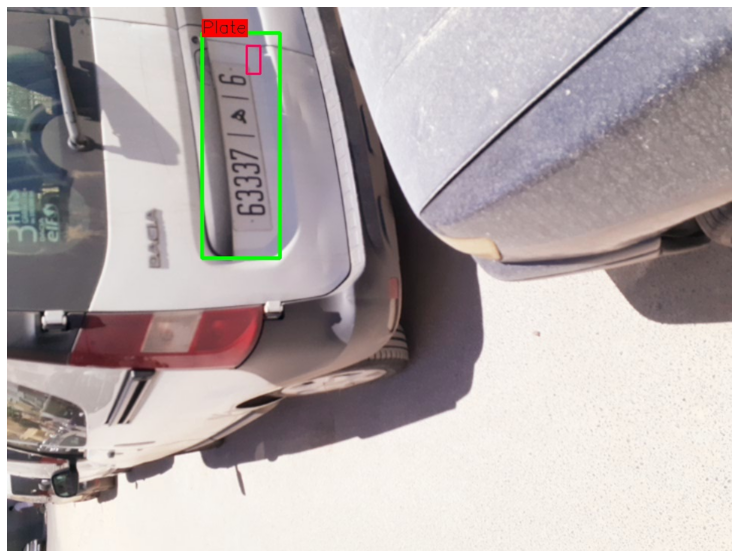

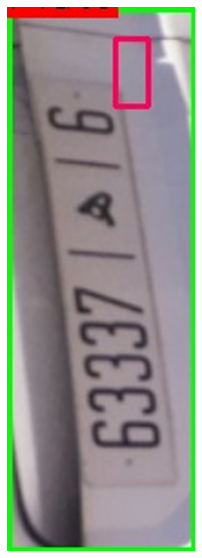

In [ ]:

# CNN prediction
license = predict('../' + saved_image, output_car_path = '../output_cnn.jpg', output_license_path_original = '../license_original_cnn.jpg', output_license_path = '../license_cnn.jpg', is_cnn=True, is_image=True)
imShow('output_cnn.jpg')
imShow('license_cnn.jpg')

In [ ]:
license

'ww'

# YOLOv3 & Flow Normalizing prediction

In [ ]:

license = predict('../' + saved_image, output_car_path = '../output_YOLO.jpg', output_license_path_original = '../license_original_YOLO.jpg', output_license_path = '../license_YOLO.jpg', is_cnn=False, is_image=True)

In [ ]:

def predict_all(filename, 
            input_path,
            video_path=None, 
            is_cnn=False, 
            is_image=True):
    input_path=filename+input_path
    stream = cv.VideoCapture(input_path)
    Frame_PS = 2
    # Limit number of frames per sec
    stream.set(cv.CAP_PROP_FPS, Frame_PS)
    if not is_image:
        vid_writer = cv.VideoWriter(video_path, cv.VideoWriter_fourcc('H','2','6','4'), 30, (
        round(stream.get(cv.CAP_PROP_FRAME_WIDTH)), round(stream.get(cv.CAP_PROP_FRAME_HEIGHT))))

    # Read Frames from the file if video, else read first frame from image
    while cv.waitKey(1) < 0:
        exists, frame = stream.read()
        if not exists:
            cv.waitKey(2000)
            print("End of frames")
            vid_writer.release()
            break
        car_image_blob = get_image_blob(frame)
        plates_yolo_net.setInput(car_image_blob)

        plates_yolo_layers = [plates_yolo_net.getLayerNames()[i[0] - 1] for i in
                              plates_yolo_net.getUnconnectedOutLayers()]
        plates_output = plates_yolo_net.forward(plates_yolo_layers)
        license_num, processed_license_plate = predict_boxes(frame, plates_output)

        if not is_cnn:
            resized_license_plate = resize_license_plate(processed_license_plate)
            license_plate_image_blob = get_image_blob(resized_license_plate)
            chars_yolo_net.setInput(license_plate_image_blob)
            chars_yolo_layers = [chars_yolo_net.getLayerNames()[i[0] - 1] for i in
                                 chars_yolo_net.getUnconnectedOutLayers()]
            chars_output = chars_yolo_net.forward(chars_yolo_layers)

            license_number, processed_license_plate = predict_boxes(processed_license_plate, chars_output, is_license_plate=False)
        elif is_cnn:
            license_number = cnn_recognize_plate(processed_license_plate)

        return license_number #Display at the shell resutl of detection

In [ ]:
import glob
from os import walk
import pandas as pd

test_path='/Users/oublal/Downloads/CNN_CharacterRecognition/dataset/9/'

data=pd.DataFrame()
#data["id_image"]=test["id_image"]
data["id_image"]=0
data["id_string"]=0
for (dirpath, dirnames, filenames) in walk(test_path):
    data["img_name"]=filenames

for (dirpath, dirnames, filenames) in walk(test_path):
    data["path"]=dirpath
   # break
data["id_string"]=data.apply(lambda x: predict_all(x.img_name, x.path,
                                                 video_path=None, is_cnn=False,is_image=True), axis=1)

submussion=data.drop(colomns=['img_name','path'])
submussion.to_csv('submission.csv',index=False)